In [1]:

/#importing dependencies
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list


Package                           Version
--------------------------------- ------------
absl-py                           2.0.0
anyio                             3.5.0
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asttokens                         2.0.5
astunparse                        1.6.3
attrs                             23.1.0
Babel                             2.11.0
backcall                          0.2.0
beautifulsoup4                    4.12.2
bleach                            4.1.0
Brotli                            1.0.9
cachetools                        5.3.2
certifi                           2023.11.17
cffi                              1.16.0
chardet                           5.2.0
charset-normalizer                2.0.4
colorama                          0.4.6
comm                              0.1.2
contourpy                         1.2.0
cryptography                      41.0.7
cycler             

In [3]:
import tensorflow as tf
import os

In [4]:
# avoid OOM eroors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [6]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
#remove dodgy images
import cv2
import imghdr
import matplotlib.pyplot as plt

In [8]:
data_dir = 'Data'
image_exts = ['jpeg','jpg','bmp','png']

In [9]:
image_exts[0]

'jpeg'

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('image not in ext list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image{}'.format(image_path))
            # os.remove(image_path)

In [11]:
import numpy as np

In [12]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 377 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
data_iterator

In [15]:
#get another batch from iterator
batch = data_iterator.next()

In [16]:
len(batch)

2

In [17]:
#image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [18]:
#class1=Rich_peoples
#class0=Poor_peoples
batch[1]

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

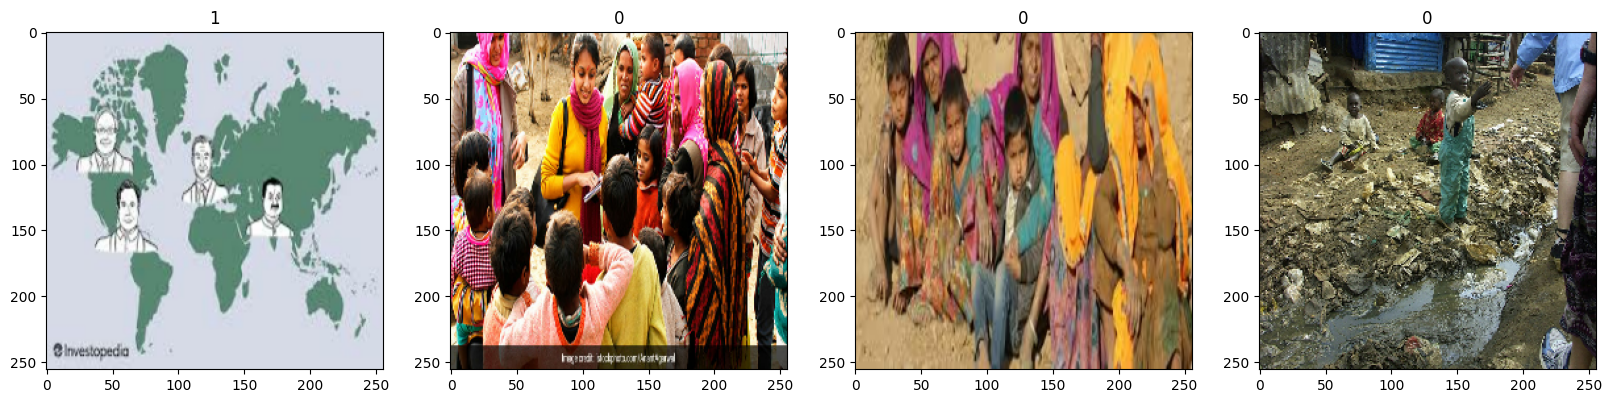

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

2. preprocess data

In [20]:
data = data.map(lambda x, y: (x/255, y))

In [21]:
scaled_iterator = data.as_numpy_iterator()

In [22]:
batch  = scaled_iterator.next()

In [23]:
batch[0].max()

1.0

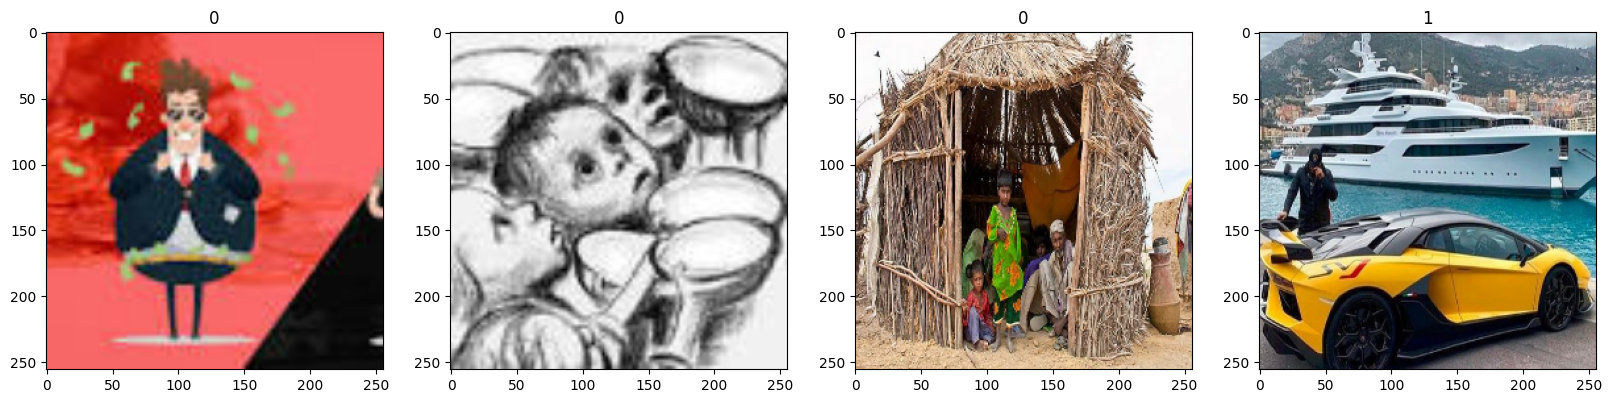

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


Split data

In [25]:
len(data)

12

In [26]:
(12*.1)+1

2.2

In [27]:
train_size = int(len(data)*.7)-1
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [28]:
train_size+val_size+test_size

12

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [30]:
len(train)

7

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [32]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation ='relu', input_shape =(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [33]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Training

In [35]:
logdir = 'logs'

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
history = model.fit(train, epochs=20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 15s 503ms/step - loss: 1.5275 - accuracy: 0.4598 - val_loss: 0.6969 - val_accuracy: 0.4688
Epoch 2/20
7/7 [==============================] - 4s 451ms/step - loss: 0.6877 - accuracy: 0.5580 - val_loss: 0.6855 - val_accuracy: 0.5625
Epoch 3/20
7/7 [==============================] - 4s 468ms/step - loss: 0.6896 - accuracy: 0.5536 - val_loss: 0.6696 - val_accuracy: 0.6146
Epoch 4/20
7/7 [==============================] - 4s 478ms/step - loss: 0.6679 - accuracy: 0.6116 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 5/20
7/7 [==============================] - 4s 454ms/step - loss: 0.6310 - accuracy: 0.6562 - val_loss: 0.6494 - val_accuracy: 0.7917
Epoch 6/20
7/7 [==============================] - 4s 438ms/step - loss: 0.6217 - accuracy: 0.6786 - val_loss: 0.5933 - val_accuracy: 0.7500
Epoch 7/20
7/7 [==============================] - 4s 453ms/step - loss: 0.5644 - accuracy: 0.7232 - val_loss: 0.5331 - val_accuracy: 0.7708
Epoch 8/20
7/7 [===

Plot performance

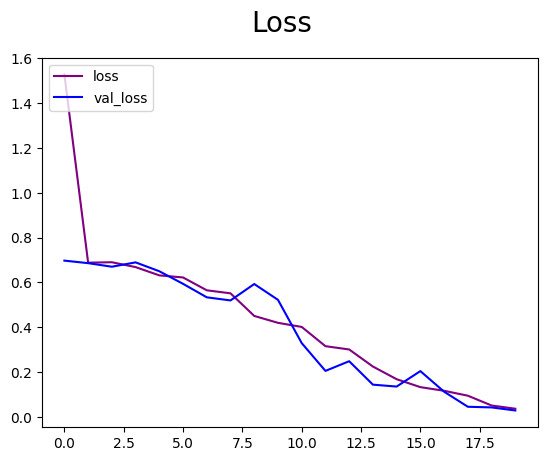

In [38]:
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

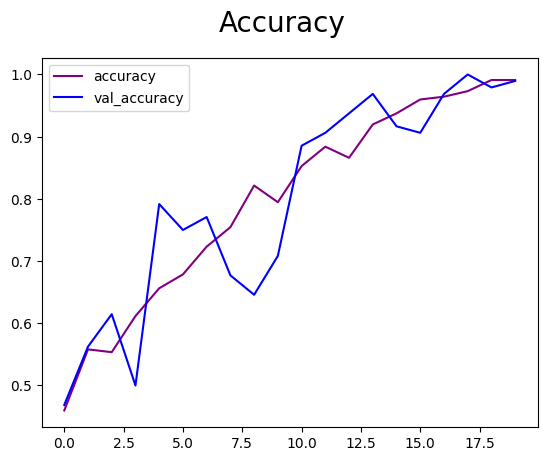

In [39]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='purple', label='accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Evaluate Performance

In [40]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [42]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 650ms/step


In [43]:
print(f' Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}') 

 Precision:1.0, Recall:1.0, Accuracy:1.0


test

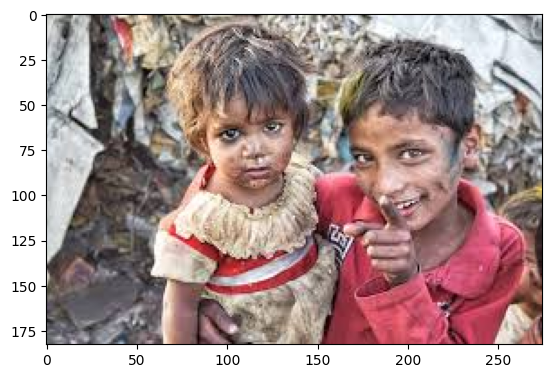

In [59]:
img = cv2.imread('download12.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

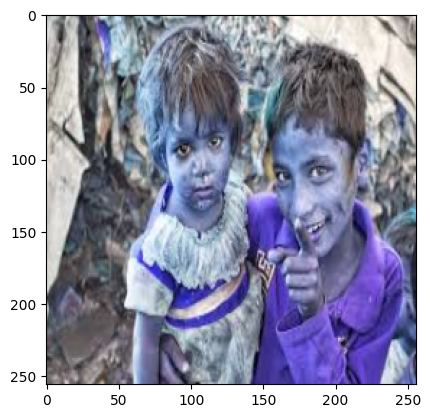

In [60]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 45ms/step


In [62]:
yhat

array([[0.01641595]], dtype=float32)

In [64]:
if yhat > 0.5:
    print(f'Person is Rich')
else:
    print(f'person is Poor')

person is Poor


Save the model

In [65]:
from tensorflow.keras.models import load_model

In [66]:
model.save(os.path.join('models','RichvsPoormodel.h5'))

In [67]:
new_model = load_model(os.path.join('models','RichvsPoormodel.h5'))

In [70]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 49ms/step


In [71]:
if yhatnew > 0.5:
    print(f'Person is Rich')
else:
    print(f'person is Poor')

person is Poor
